In [111]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import math
from copy import deepcopy

import pandas as pd

In [112]:
class DrowsinessData(Dataset):
    def __init__(self,data, trn_val_tst, transform=None):

        # split_idx1 = int(data.shape[0]*0.6)
        # split_idx2 = int(data.shape[0]*0.8)
        # if trn_val_tst == 0:
        #     #trainloader
        #     self.X = data.iloc[0:split_idx1, 0:-1].to_numpy()
        #     self.labels = data.iloc[0:split_idx1, -1].to_numpy()
        # elif trn_val_tst == 1:
        #     #valloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()
        # else:
        #     #testloader
        #     self.X = data.iloc[split_idx1:split_idx2, 0:-1].to_numpy()
        #     self.labels = data.iloc[split_idx1:split_idx2, -1].to_numpy()

        self.X = data.iloc[:, 0:-1].to_numpy()
        self.labels = data.iloc[:, -1].to_numpy()
        self.labels[self.labels < 6.5] = 0
        self.labels[self.labels >= 6.5] = 1

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.X[idx,:]
        label = self.labels[idx]

        # if self.transform:
        #     sample = self.transform(sample)
        sample = torch.from_numpy(sample).type(torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sample, label

In [113]:
train_data = pd.read_csv("../Features_and_Labels/30s/train_features_and_labels_30s.csv")
valid_data = pd.read_csv("../Features_and_Labels/30s/valid_features_and_labels_30s.csv")
test_data = pd.read_csv("../Features_and_Labels/30s/test_features_and_labels_30s.csv")


filter_features = {
    "mrmr": {
        "30": ['Sh_Ent1', 'MDF', 'bandPower(){}_2_beta', 'lf_hf_ratio', 'LZC(){}_1', 'MNF', 'sampEn(){}_2', 'PKF', 'ZC', 'csi', 'bandPower(){}_2_alpha', 'DFA(){}_2', 'Sh_Ent0', 'Sp_ent2', 
               'blinking_rate', 'LZC(){}_2', 'WENT', 'hjorthMobility(){}_2', 'bandPower(){}_1_beta', 'pnni_20', 'PFD(){}_1', 'hjorthComplexity(){}_2', 'bandPower(){}_2_theta', 'wave_ent2', 
               'lfnu', 'LOG', 'HFD(){}_2', 'pnni_50', 'bandPower(){}_1_alpha', 'sampEn(){}_1', 'kss']
    },
    "kbest": {
        "30": ['bandPower(){}_1_alpha', 'bandPower(){}_1_beta', 'bandPower(){}_2_theta', 'bandPower(){}_2_alpha', 'bandPower(){}_2_beta', 'hjorthMobility(){}_1', 'hjorthMobility(){}_2', 
        'hjorthComplexity(){}_2', 'sampEn(){}_1', 'sampEn(){}_2', 'DFA(){}_2', 'PFD(){}_1', 'PFD(){}_2', 'LZC(){}_1', 'LZC(){}_2', 'Sh_Ent0', 'fuzzy0', 'Sp_ent2', 'wave_ent2', 'lf_hf_ratio', 
        'lfnu', 'csi', 'LOG', 'ZC', 'MYOP', 'MNF', 'MDF', 'PKF', 'WENT', 'blinking_rate', 'kss']
    }
}

ttest_features = ["bandPower(){}_0_theta", "bandPower(){}_0_alpha", "bandPower(){}_0_beta",	"bandPower(){}_1_delta", "bandPower(){}_2_alpha", "bandPower(){}_2_beta", 
                  "hjorthActivity(){}_1", "hjorthActivity(){}_2", "hjorthMobility(){}_0", "hjorthMobility(){}_2", "hjorthComplexity(){}_0",	"hjorthComplexity(){}_2", "sampEn(){}_2", 
                  "DFA(){}_0", "DFA(){}_2", "PFD(){}_2", "LZC(){}_0", "LZC(){}_1",	"LZC(){}_2", "fuzzy0", "Sp_ent0", "EEG_kurt0",	"Sp_ent1",	"wave_ent1", "EEG_kurt1", "Multiscale2", 
                  "Sp_ent2", "wave_ent2", "EEG_mean2", "EEG_kurt2", "cvnni",	"max_hr", "nni_20",	"nni_50", "pnni_20", "pnni_50",	"range_nni", "fuzzy",	"sdsd",	"std_hr", "lf",	"hf", 
                  "lf_hf_ratio", "lfnu", "total_power",	"vlf",	"csi",	"RMS", "IEMG",	"MAV",	"LOG",	"ZC", "WAMP", "MNF", "MDF",	"PKF", "WENT", "blinking_rate",	"MAR_mean",	"vtilt_mean", 
                  "htilt_std", "kss"]


train_data = train_data.loc[:, filter_features["kbest"]["30"]]
valid_data = valid_data.loc[:, filter_features["kbest"]["30"]]
test_data = test_data.loc[:, filter_features["kbest"]["30"]]

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)

train_set = DrowsinessData(train_data, trn_val_tst=0) 
val_set = DrowsinessData(valid_data, trn_val_tst=1)
test_set = DrowsinessData(test_data, trn_val_tst=2)

batch_size = 100 
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

validloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

testloader =  DataLoader(test_set, batch_size=batch_size, shuffle=False)

num_features = train_set.X.shape[1]

(2226, 31)
(605, 31)
(697, 31)


In [114]:
#This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader, loss_fun):
    
    #initialise counter
    epoch_acc = 0
    total_loss = 0
    total_count = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    #(More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Forward pass of image through network
            fx = model(x.to(device))
            y = y.type(torch.FloatTensor)
            
            #log the cumulative sum of the acc
            epoch_acc += (np.round(fx.cpu().detach()) == y).sum()
            total_count += y.shape[0]
            
            #calculate the loss
            loss = loss_fun(fx, y.to(device))
            total_loss += loss.item()
    #return the accuracy from the epoch     
    return epoch_acc / total_count, total_loss

In [115]:
#This function should perform a single training epoch using our training data
def train(model, device, loader, optimizer, loss_fun, loss_logger):
    
    #Set Network in train mode
    model.train()
    
    count = 0
    total_loss = 0
    
    for i, (x, y) in enumerate(loader):
        #Perform a single epoch of training on the input dataloader, logging the loss at every step 
        #Forward pass of image through network and get output
        fx = model(x.to(device))
        y = y.type(torch.FloatTensor)

        #Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))
        
        total_loss += loss.item()
        
        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()

    #log the loss PER EPOCH for plotting
    loss_logger.append(total_loss)
   
    #return the logger array       
    return loss_logger

In [116]:
class DrowsyNet(nn.Module):
    def __init__(self, channels_in):
        # calling the init function of the parent nn.Module
        super(DrowsyNet, self).__init__()
        
        # defining the fully connected layers
        print(channels_in)
        self.fc1 = nn.Linear(int(channels_in), int(channels_in//1.5))
        self.fc2 = nn.Linear(int(channels_in//1.5), int(channels_in//3))
        self.fc3 = nn.Linear(int(channels_in//3), 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Passing it through fc layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [117]:
# Creating the model
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
model = DrowsyNet(num_features).to(device)
print(model)

pytorch_total_params = sum([p.numel() for p in model.parameters()])
pytorch_total_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(pytorch_total_params, pytorch_total_trainable_params)

learning_rate =1e-5
start_epoch = 0
num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fun = nn.BCELoss()

30
DrowsyNet(
  (fc1): Linear(in_features=30, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
841 841


In [118]:
training_loss_logger = []
validation_loss_logger = []
testing_loss_logger = []

valid_acc_logger = []
test_acc_logger = []

loewst_val_loss = math.inf


#This cell implements our training loop
for epoch in range(start_epoch, num_epochs):
    #call the training function and pass training dataloader etc
    training_loss_logger = train(model, device, trainloader, optimizer, loss_fun, training_loss_logger)
    train_acc, _ = evaluate(model, device, trainloader, loss_fun)
    #call the evaluate function and pass the dataloader for both ailidation and training
    
    valid_acc, valid_loss = evaluate(model, device, validloader, loss_fun)
    validation_loss_logger.append(valid_loss)
    valid_acc_logger.append(valid_acc)


    test_acc, test_loss = evaluate(model, device, testloader, loss_fun)
    testing_loss_logger.append(test_loss)
    test_acc_logger.append(test_acc)

    if epoch == 300:
        learning_rate /=10
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    # Copying the model with the highest validation accuracy
    if valid_loss < loewst_val_loss:
        lowest_val_loss_epoch = epoch
        loewst_val_loss = valid_loss
        lowest_val_loss_model = deepcopy(model)
    
    clear_output(True)
    print(f'| Epoch: {epoch+1:02} | Training Loss: {training_loss_logger[-1]:05.2f} | Validation Loss: {validation_loss_logger[-1]:05.2f} | Testing Loss: {testing_loss_logger[-1]:05.2f}')
    print(f'| Epoch: {epoch+1:02} | Training Acc: {train_acc*100:05.2f}% | Validation Acc: {valid_acc*100:05.2f}% | Testing Acc: {test_acc*100:05.2f}%')
print("Training Complete")
print(f'Lowest Validation Loss: {loewst_val_loss}')

| Epoch: 500 | Training Loss: 08.66 | Validation Loss: 04.54 | Testing Loss: 04.73
| Epoch: 500 | Training Acc: 85.98% | Validation Acc: 75.70% | Testing Acc: 67.58%
Training Complete
Lowest Validation Loss: 4.5005218386650085


Text(0.5, 1.0, 'Testing Accuracy')

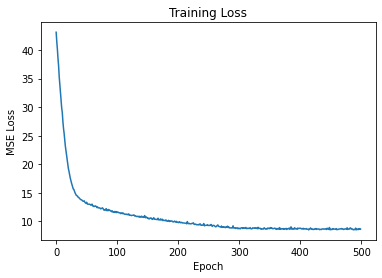

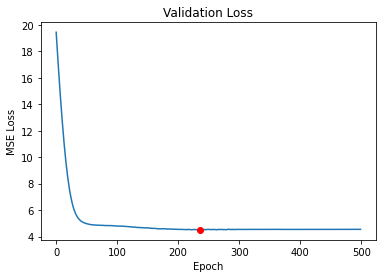

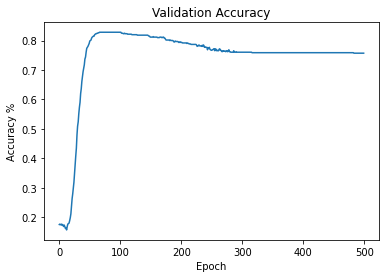

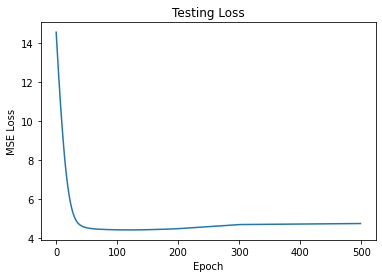

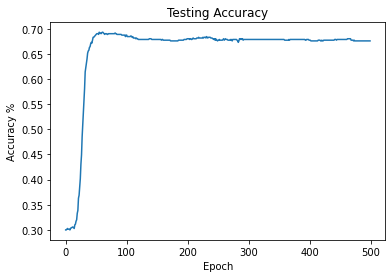

In [120]:
# Plotting
plt.figure(1)
plt.plot(training_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Training Loss")

plt.figure(2)
plt.plot(validation_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Validation Loss")
plt.plot(lowest_val_loss_epoch, loewst_val_loss, "ro")

plt.figure(22)
plt.plot(valid_acc_logger)
plt.ylabel("Accuracy %")
plt.xlabel("Epoch")
plt.title("Validation Accuracy")


plt.figure(3)
plt.plot(testing_loss_logger)
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.title("Testing Loss")

plt.figure(33)
plt.plot(test_acc_logger)
plt.ylabel("Accuracy %")
plt.xlabel("Epoch")
plt.title("Testing Accuracy")

In [121]:
# Saving model
torch.save(lowest_val_loss_model.state_dict(), "D:/School/Drowsiness-Detection-FYP/neural_network/classification/best_model.pt")
